In [3]:
#importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,f1_score,confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,Normalizer,QuantileTransformer,PowerTransformer
from sklearn.decomposition import PCA
import optuna

In [4]:
import random
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(seed=42)

In [5]:

input_dir = 'data/'

train_features = pd.read_csv(input_dir+'train_features.csv')
train_targets_scored = pd.read_csv(input_dir+'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(input_dir+'train_targets_nonscored.csv')
test_features = pd.read_csv(input_dir+'test_features.csv')
sample_submission = pd.read_csv(input_dir+'sample_submission.csv')
train_drug = pd.read_csv(input_dir+'train_drug.csv')

In [6]:
#list of names of the MoAs in the dataset
target_cols_scored=[col for col in train_targets_scored.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored.columns if col not in ['sig_id']]

In [7]:
#separating gene feautres and cell features in a separate list
#we know that all the gene expression features name starts with 'g-' and cell features name starts with 'c-', hence trying to observe set of all the gene expression as one function and all the cell functions as one features
gene_features=[]
cell_features=[]
for i in train_features.columns:
    if i.startswith('g-'):
        gene_features.append(i)
    if i.startswith('c-'):
        cell_features.append(i)

In [8]:
#merging the train dataset and train target scored dataset into one
train_merge=pd.merge(train_features,train_targets_scored,on="sig_id",how="left")

In [9]:
train_merge=train_merge[train_merge['cp_type']!='ctl_vehicle']
#test_features1=test_features.copy()
test_features1=test_features[test_features['cp_type']!='ctl_vehicle']

In [10]:
train_merge.drop(columns=['cp_type'],inplace=True)
test_features1.drop(columns=['cp_type'],inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [12]:
from sklearn.decomposition import PCA



def PCA_decomposition(train,valid,test,n_comp_gene,n_comp_cell,seed):
     '''
    function is used to generate pca components of gene and cell features of train, validationa and test set
    Args:
        train:train dataset
        valid:validation dataset
        test:test dataset
        n_comp_gene: number of PCA components for gene features
        n_comp_cell: number of PCA components for cell features
        
    Returns:
    
        train:train dataset with concatenation of pca generated features
        valid:validation dataset with concatenation of pca generated features
        test:test dataset with concatenation of pca generated features
        
    '''
    pca_gene_feat=[f'pca_gene_{col}' for col in range(n_comp_gene)]
    pca_cell_feat=[f'pca_cell_{col}' for col in range(n_comp_cell)]
    pca_gene=PCA(n_components=n_comp_gene,random_state=seed)
    X_train_pca_gene=pd.DataFrame(pca_gene.fit_transform(train[gene_features]),columns=pca_gene_feat).reset_index(drop=True)
    X_valid_pca_gene=pd.DataFrame(pca_gene.transform(valid[gene_features]), columns=pca_gene_feat).reset_index(drop=True)
    X_test_pca_gene=pd.DataFrame(pca_gene.transform(test[gene_features]), columns=pca_gene_feat).reset_index(drop=True)

    pca_cell=PCA(n_components=n_comp_cell,random_state=seed)
    X_train_pca_cell=pd.DataFrame(pca_cell.fit_transform(train[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    X_valid_pca_cell=pd.DataFrame(pca_cell.transform(valid[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    X_test_pca_cell=pd.DataFrame(pca_cell.transform(test[cell_features]), columns=pca_cell_feat).reset_index(drop=True)
    
    train=pd.concat([train.reset_index(drop=True),X_train_pca_gene,X_train_pca_cell],axis=1)
    valid=pd.concat([valid.reset_index(drop=True),X_valid_pca_gene,X_valid_pca_cell],axis=1)
    test=pd.concat([test.reset_index(drop=True),X_test_pca_gene,X_test_pca_cell],axis=1)
    return train,valid,test
    

In [13]:
from sklearn.preprocessing import QuantileTransformer
def quantile_scaling(train,valid,test):
      '''
       takes in input, valid, test for quantile transformation
       Args:
            train:train dataset
            valid:validation dataset
            test:test dataset
       Returns:
            train: transformed train dataset
            valid: transformed validation dataset
            test:  transformed test dataset
        
        '''
       qt=QuantileTransformer(output_distribution='normal')
       train=pd.DataFrame(qt.fit_transform(train),index=train.index,columns=train.columns)
       valid=pd.DataFrame(qt.fit_transform(valid),index=valid.index,columns=valid.columns)
       test=pd.DataFrame(qt.fit_transform(test),index=test.index,columns=test.columns)
       return train,valid,test

In [14]:
lb=LabelEncoder()
lb.fit(train_merge['cp_time'])

train_merge['cp_time']=lb.transform(train_merge['cp_time'])
test_features1['cp_time']=lb.transform(test_features1['cp_time'])
##################################################################################
lb1=LabelEncoder()
lb1.fit(train_merge['cp_dose'])

train_merge['cp_dose']=lb1.transform(train_merge['cp_dose'])
test_features1['cp_dose']=lb1.transform(test_features1['cp_dose'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [15]:
######## SELECTING THE 33- MOST Correlated non-scored targets ########
nonctr_id = train_features.loc[train_features['cp_type']!='ctl_vehicle','sig_id'].tolist()
tmp_con1 = [i in nonctr_id for i in train_targets_scored['sig_id']]
mat_cor = pd.DataFrame(np.corrcoef(train_targets_scored.drop('sig_id',axis = 1)[tmp_con1].T,
                      train_targets_nonscored.drop('sig_id',axis = 1)[tmp_con1].T))
mat_cor2 = mat_cor.iloc[(train_targets_scored.shape[1]-1):,0:train_targets_scored.shape[1]-1]
mat_cor2.index = target_cols_nonscored
mat_cor2.columns = target_cols_scored
mat_cor2 = mat_cor2.dropna()
mat_cor2_max = mat_cor2.abs().max(axis = 1)

q_n_cut = 0.9
target_cols_nonscored2= mat_cor2_max[mat_cor2_max > np.quantile(mat_cor2_max,q_n_cut)].index.tolist()
print(len(target_cols_nonscored2))

33


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [16]:
train_merge=train_merge.merge(train_targets_nonscored[['sig_id']+target_cols_nonscored2],on='sig_id',how='left')

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [18]:
def model_cnn(feature_cols):
    inp=Input(shape=(feature_cols,))

    

    x=BatchNormalization()(inp)
    x=Dropout(0.4787504007157003)(x)
    x=tfa.layers.WeightNormalization(Dense(4096,activation='relu'))(x)
    x=tf.reshape(x,shape=[-1,16,256])

    ##################################################################################

    x=BatchNormalization()(x)
    x=Dropout(0.5385338128727387)(x)
    x=tfa.layers.WeightNormalization(Conv1D(512,kernel_size=5,padding='same',activation='elu',use_bias=False))(x)

    ################################################################################################
    x=AveragePooling1D(pool_size=2)(x)
    ################################################################################################

    x=BatchNormalization()(x)
    x=Dropout(0.1652790888524694)(x)
    x=tfa.layers.WeightNormalization(Conv1D(512,3,padding='same',activation='selu',use_bias=True))(x)

    ################################################################################################
    x_s=x
    x=BatchNormalization()(x)
    x=Dropout(0.8657514109536817)(x)
    x=tfa.layers.WeightNormalization(Conv1D(512,3,padding='same',activation='elu',use_bias=True))(x)

    ##################################################################################################

    x=BatchNormalization()(x)
    x=Dropout(0.8314610852701898)(x)
    x=tfa.layers.WeightNormalization(Conv1D(512,5,padding='same',activation='relu',use_bias=True))(x)

    ##################################################################################################
    x=x*x_s
    x=MaxPool1D(pool_size=2)(x)

    flat=Flatten()(x)

    #####################################################################################################

    x=BatchNormalization()(flat)
    x=Dropout(0.26386199441422953)(x)
    output=Dense(33,activation='sigmoid')(x)
    
    ########################################################################################################
    model=tf.keras.Model(inputs=inp,outputs=output)
    return inp,flat,model

In [19]:
feature_groups=gene_features+cell_features+['cp_time','cp_dose']

In [20]:
test_dataset=test_features1[feature_groups]

In [21]:
#define frequency table
def f_table(list1):
    table_dic={}
    for i in list1:
        if i not in table_dic.keys():
            table_dic[i]=1
        else:
            table_dic[i]+=1
    return table_dic

In [22]:
from copy import deepcopy as dp


In [23]:
tar_freq = np.array([np.min(list(f_table(train_merge[target_cols_scored].iloc[:,i]).values())) for i in range(len(target_cols_scored))])
tar_weight0 = np.array([np.log(i+100) for i in tar_freq])
tar_weight0_min = dp(np.min(tar_weight0))
tar_weight = tar_weight0_min/tar_weight0

In [24]:
from tensorflow.keras import backend
def logloss1(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,0.001,0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [25]:
import tensorflow_addons as tfa


In [35]:
%matplotlib inline

In [38]:
def plot_loss(history2,seed,fold):
    %matplotlib inline
    #print history loss validation and training
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.ylabel('LOSS')
    plt.xlabel('epoch')
    plt.title(f'LOSS vs EPOCHS for seed{seed} and fold{fold}')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.plot()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=660 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


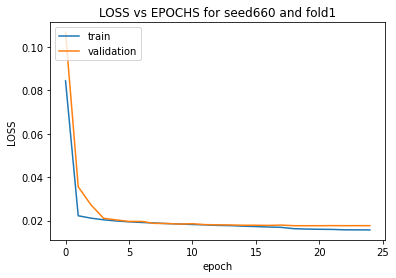

Executing fold1


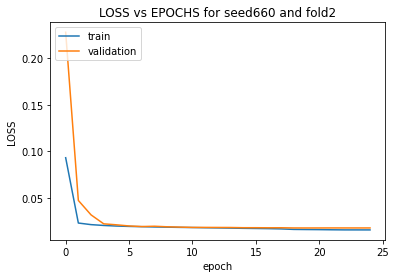

Executing fold2


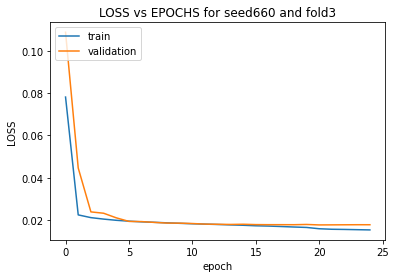

Executing fold3


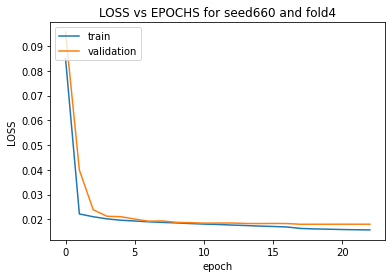

Executing fold4


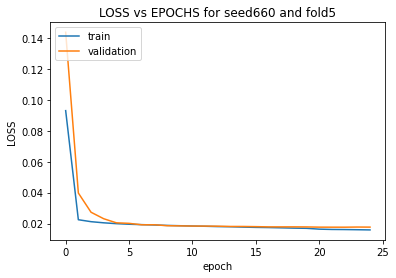

Executing fold5


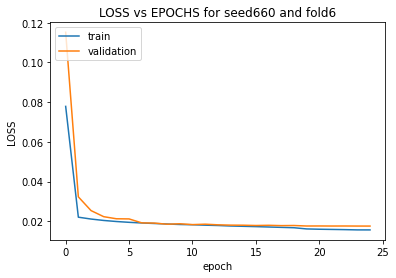

Executing fold6


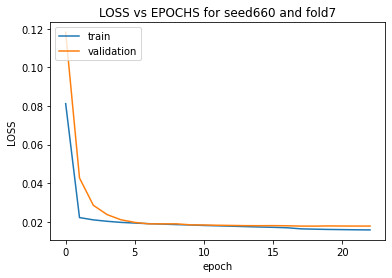

Executing fold7


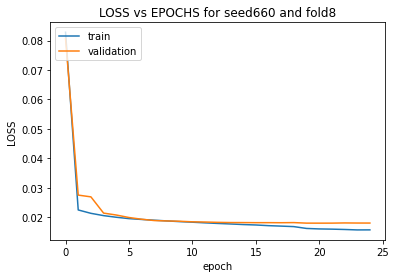

Executing fold8


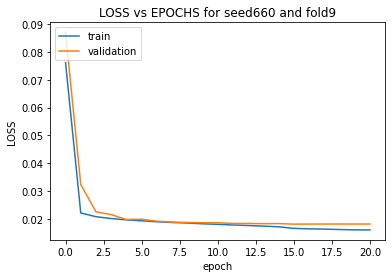

Executing fold9


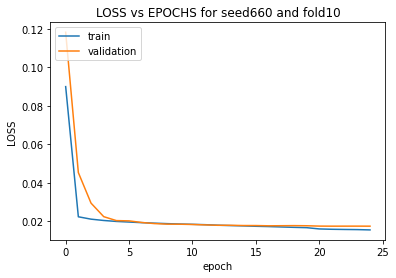

Executing fold10
End of Seed660


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


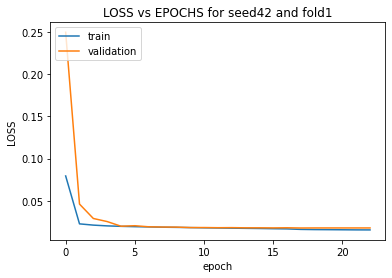

Executing fold1


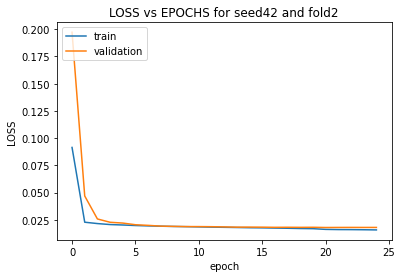

Executing fold2


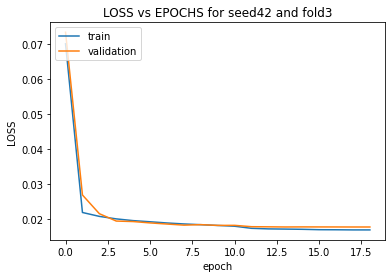

Executing fold3


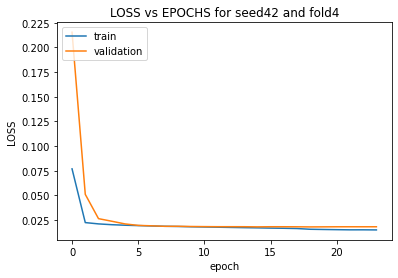

Executing fold4


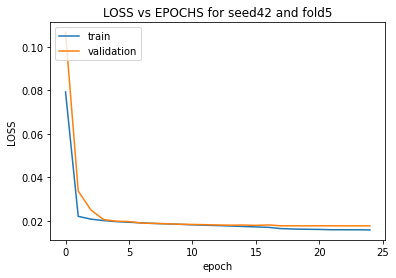

Executing fold5


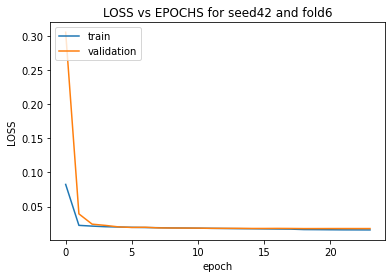

Executing fold6


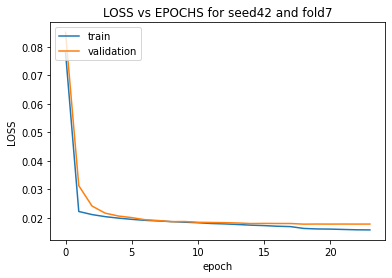

Executing fold7


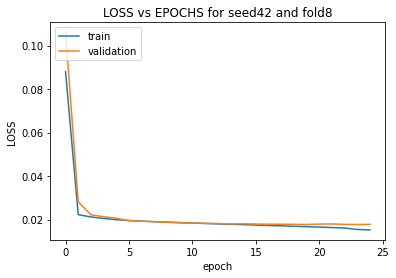

Executing fold8


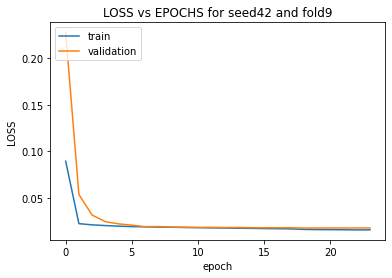

Executing fold9


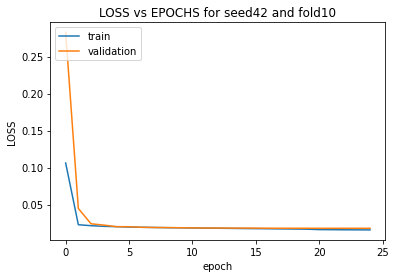

Executing fold10
End of Seed42


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=2020 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


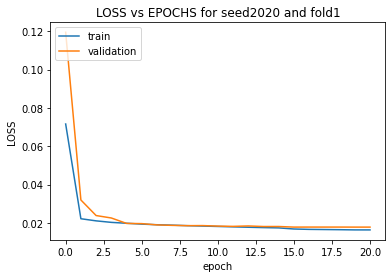

Executing fold1


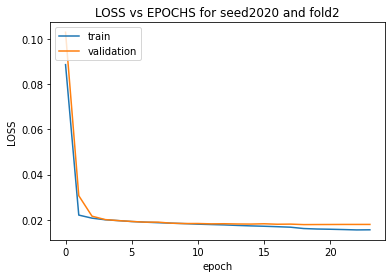

Executing fold2


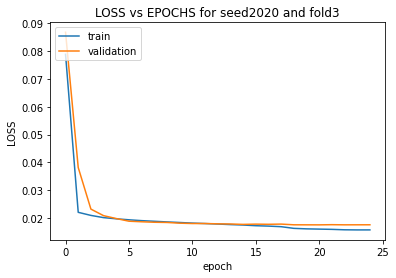

Executing fold3


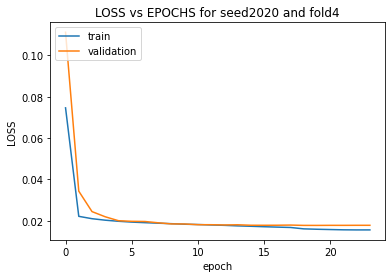

Executing fold4


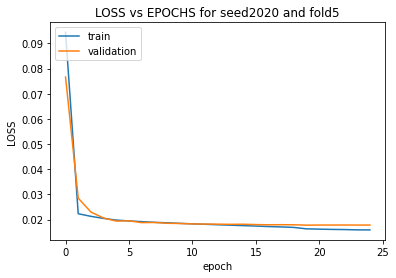

Executing fold5


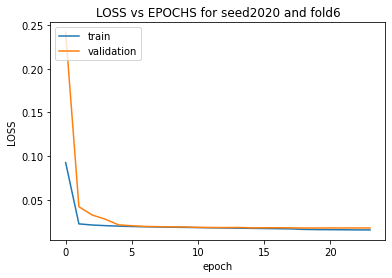

Executing fold6


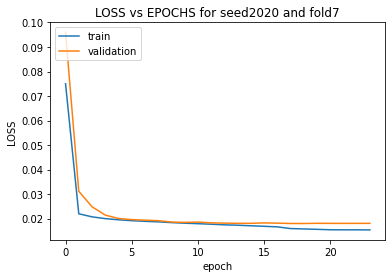

Executing fold7


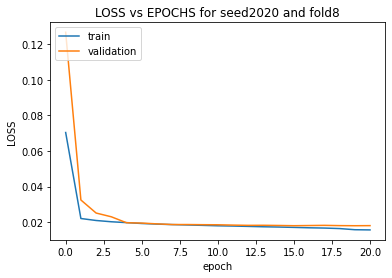

Executing fold8


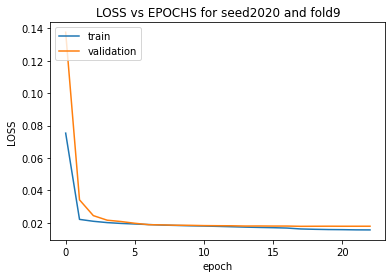

Executing fold9


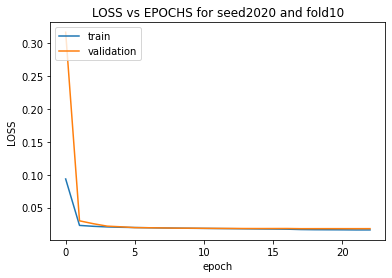

Executing fold10
End of Seed2020


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


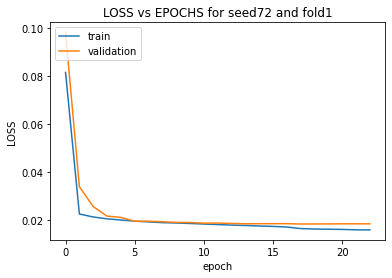

Executing fold1


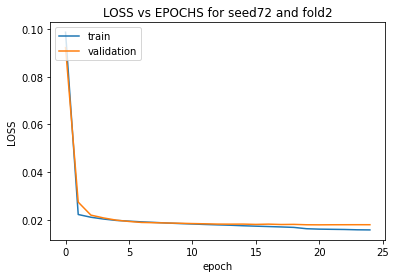

Executing fold2


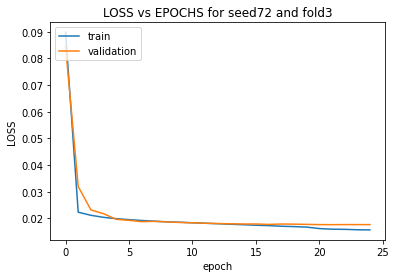

Executing fold3


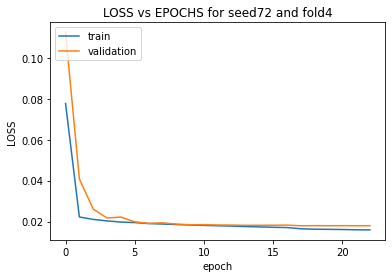

Executing fold4


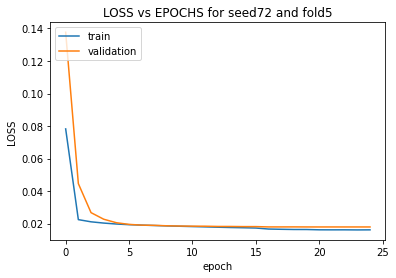

Executing fold5


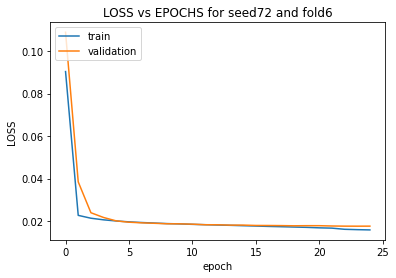

Executing fold6


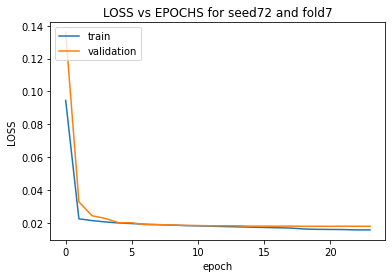

Executing fold7


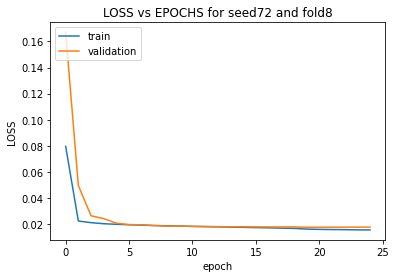

Executing fold8


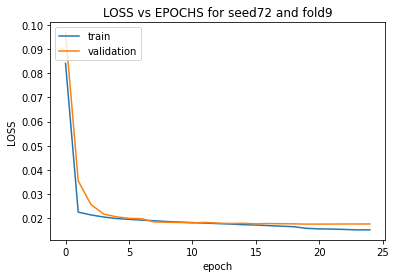

Executing fold9


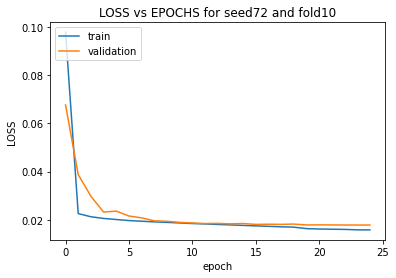

Executing fold10
End of Seed72


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


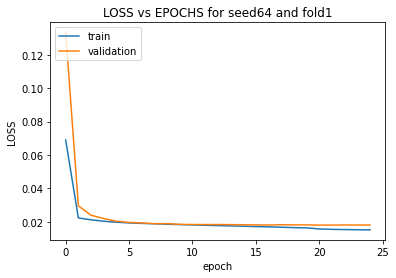

Executing fold1


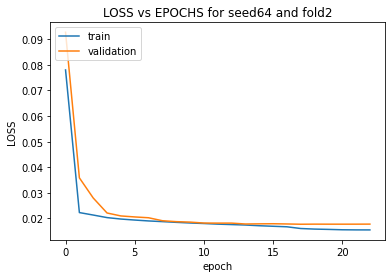

Executing fold2


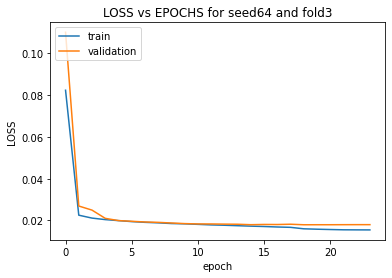

Executing fold3


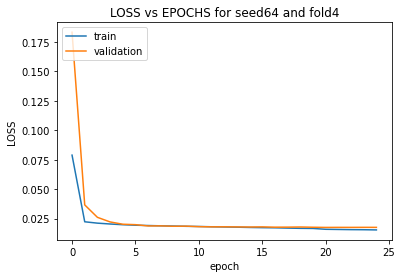

Executing fold4


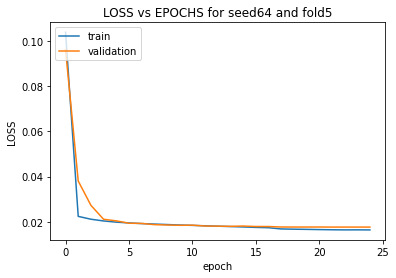

Executing fold5


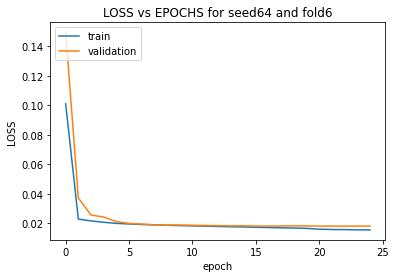

Executing fold6


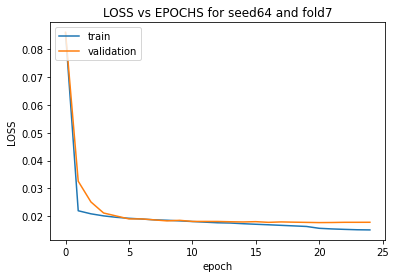

Executing fold7


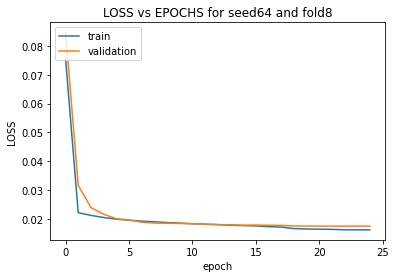

Executing fold8


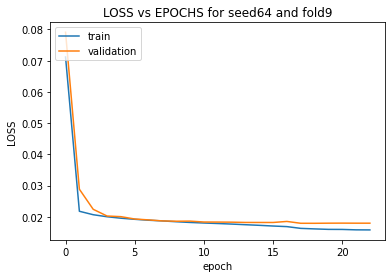

Executing fold9


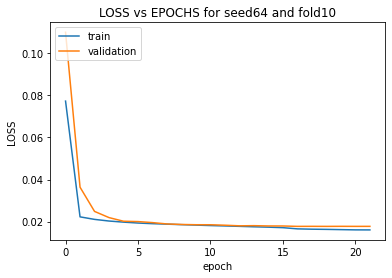

Executing fold10
End of Seed64


In [46]:
#fold=0
SEEDS=[660,42,2020,72,64]
n_folds=10
n_comp_gene=46
n_comp_cell=31
oof_seed_level = np.zeros((len(train_merge), len(target_cols_scored)))
y_pred_seed_level = np.zeros((len(test_features1), len(target_cols_scored)))
#Training is done across 5 different seeds and 10 differents folds to address the diversity in the dataset
#Remeber we need to have same seeds in all the models for ensembling
for seed in SEEDS:
    oof_fold_level = np.zeros((len(train_merge), len(target_cols_scored)))
    y_pred_fold_level = np.zeros((len(test_features1), len(target_cols_scored)))
    seed_everything(seed=42)
    fold=0
    mskf = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=seed)
    y_pred_fold_level=np.zeros((len(test_features1),206))
    oof_fold_level=np.zeros((len(train_merge),206))
    for train_idx, test_idx in mskf.split(train_merge[feature_groups],train_merge[target_cols_scored]):
            train_df=train_merge.iloc[train_idx]
            valid_df=train_merge.iloc[test_idx]

            #label_train=Y[target_cols_scored].iloc[train_idx]
            #label_validation=Y[target_cols_scored].iloc[test_idx]

            test1=test_dataset.copy()
            x_train, y_train,y_train_ns = train_df[feature_groups], train_df[target_cols_scored].values,train_df[target_cols_nonscored2].values
            x_valid, y_valid,y_valid_ns  =  valid_df[feature_groups], valid_df[target_cols_scored].values,valid_df[target_cols_nonscored2].values
            x_test = test_features1[feature_groups]

            #------------ norm --------------

            

            x_train,x_valid,x_test=PCA_decomposition(x_train,x_valid,x_test,n_comp_gene,n_comp_cell,seed)
            x_train,x_valid,x_test=quantile_scaling(x_train,x_valid,x_test)
            #------------ pca --------------

            x_train,x_valid,x_test = x_train.values,x_valid.values,x_test.values
            inp,flat,model=model_cnn(x_train.shape[1])
            model.compile(optimizer=tf.keras.optimizers.Adam(0.016637257847200278,decay= 0.0003535587959774414),loss=tf.keras.losses.BinaryCrossentropy())
            history1=model.fit(x_train,y_train_ns,epochs=2,batch_size=128,validation_data=(x_valid,y_valid_ns),verbose=0)

            ################################################CALLBACKS############################################################################################

            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.14357311529640565, patience=3, mode='min', min_lr=1E-5)
            early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1E-5, patience=5, mode='min',restore_best_weights=True)

            #################################################FINE-TUNING ON TARGET COLUMNS SCORED################################################################
            for layer in model.layers:
                layer.trainalble=False
            final_layer=Dense(206,activation='sigmoid')(flat)
            model_new=tf.keras.Model(inputs=model.input,outputs=final_layer)
            model_new.compile(optimizer=tf.keras.optimizers.Adam( 0.010273058742845193,decay=0.0002558583664245617),loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001),loss_weights=tar_weight)
            history2=model_new.fit(x_train,y_train,epochs=25,batch_size=128,validation_data=(x_valid,y_valid),callbacks=[reduce_lr,early_stopping],verbose=0)
            
         
            model_new.save(f'model_cnn_seed{seed}_fold{fold}.h5')
            oof_fold_level[test_idx]=model_new.predict(x_valid)
            predictions=model_new.predict(x_test)
            y_pred_fold_level=y_pred_fold_level+predictions
            fold=fold+1
            %matplotlib inline
            #print history loss validation and training
            plt.plot(history2.history['loss'])
            plt.plot(history2.history['val_loss'])
            plt.ylabel('LOSS')
            plt.xlabel('epoch')
            plt.title(f'LOSS vs EPOCHS for seed{seed} and fold{fold}')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.plot()
            plt.pause(0.0001)
            print(f'Executing fold{fold}')
    print(f'End of Seed{seed}')
    oof_seed_level=oof_seed_level+oof_fold_level
    y_pred_seed_level+=y_pred_fold_level
        


<h2>OBSERVATION </h2>

One thing we can clearly observe from the plots that there is no case of overfitting.

In [47]:
y_pred_seed_level=y_pred_seed_level/(n_folds*len(SEEDS))

In [48]:
oof_seed_level=oof_seed_level/(len(SEEDS))

In [50]:
sig_id=[]
for i in test_features['sig_id']:
     if i not in test_features1['sig_id'].values:
            sig_id.append(i)

In [51]:
sig_id=np.array(sig_id).reshape(len(sig_id),1)
sig_id.shape

(358, 1)

In [52]:
len(sig_id)
non_essentials=np.zeros((len(sig_id),len(target_cols_scored)))
non_essentials=np.hstack((sig_id,non_essentials))
non_essentials.shape

(358, 207)

In [53]:
prediction1=np.hstack((test_features1['sig_id'].values.reshape(-1,1),y_pred_seed_level))
prediction1.shape

(3624, 207)

In [54]:
prediction1=np.vstack((prediction1,non_essentials))
prediction1.shape

(3982, 207)

In [55]:
columns1=['sig_id']
columns1.extend(target_cols_scored)

In [56]:
submission=pd.DataFrame(prediction1,columns=[i for i in columns1])

In [57]:
submission.to_csv("submission.csv",index=False)